In [1]:
import os, datetime, time, re, warnings, gc, json, random, yaml, umap, pickle

from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import multiprocessing
from multiprocessing import Pool

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, f1_score
from sklearn import datasets, manifold, mixture, model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import MiniBatchKMeans

from scipy.sparse import vstack, csr_matrix, save_npz, load_npz, hstack

from gensim import corpora, models, similarities
from gensim.models import Word2Vec

import lightgbm as lgb
import optuna.integration.lightgbm as tuna

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", 256)
pd.set_option("display.max_rows", 256)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    print(f'[{title}] start')
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
class FeatureEngineering(metaclass=ABCMeta):
    BASE_DIR = "."
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_train"
        self.test_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_test"
    
    @abstractmethod
    def load_data(self):
        raise NotImplementedError

    @abstractmethod
    def create_features(self):
        raise NotImplementedError
        
    def run(self, use_columns=[], skip_columns=[]):
        with timer(self.name):
            self.load_data()
            self.replace_na(use_columns=use_columns, skip_columns=skip_columns)
            self.onehot_encode(use_columns=use_columns, skip_columns=skip_columns)
            self.create_features()
        
        return self
    
    def onehot_encode(self, use_columns=[], skip_columns=[], sparse=False):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        self.label_encode(use_columns, skip_columns)
        if sparse:
            encoder = OneHotEncoder(categories='auto', sparse=sparse, dtype='uint8').fit(pd.concat([self.train.loc[:, use_columns], self.test.loc[:, use_columns]]))
            m = 100000
            train = vstack([encoder.transform(self.train[i*m:(i+1)*m].loc[:, use_columns]) for i in range(self.train.shape[0] // m + 1)])
            test  = vstack([encoder.transform(self.test[i*m:(i+1)*m].loc[:, use_columns])  for i in range(self.test.shape[0] // m +  1)])
            save_npz(f"{self.train_file_path}.npz", train, compressed=True)
            save_npz(f"{self.test_file_path}.npz",  test,  compressed=True)
        else:
            self.train["is_train_date"] = 1
            self.test["is_train_date"]  = 0
            df = pd.concat([self.train, self.test])
            del self.train, self.test
            gc.collect()
            for col in use_columns:
                df = df.join(pd.get_dummies(df[col], prefix=col))
            
            self.train = df[df["is_train_date"]==1]
            self.test = df[df["is_train_date"]==0]
            self.train.drop(columns="is_train_date", inplace=True)
            self.test.drop(columns="is_train_date", inplace=True)
            
        return self
    
    def label_encode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        for col in use_columns:
            if df[col].dtype.name in ["object", "category"]:
                df[col] = df[col].astype(str)
                le = LabelEncoder().fit(df[col])
                df[col] = le.transform(df[col])+1
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
    
        return self
    
    def target_encode(self, col_name, target_name, min_samples_leaf=1, smoothing=1, noise_level=0):
        trn_series = self.train[col_name]
        tst_series = self.test[col_name]
        target = self.train[target_name]
        
        assert len(trn_series) == len(target)

        temp = pd.concat([trn_series, target], axis=1)
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
        prior = target.mean()
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(["mean", "count"], axis=1, inplace=True)
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_trn_series.index = trn_series.index 
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_tst_series.index = tst_series.index

        self.train[f"te_smoothing_{col_name}"], self.test[f"te_smoothing_{col_name}"] = self.__add_noise(ft_trn_series, noise_level), self.__add_noise(ft_tst_series, noise_level)
        
        return self
    
    def agg_transform(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"

        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
            
        for k, v in agg.items():
            if type(v) is str:
                df[f"{prefix}{k}_{v}"] = df.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    df[f"{prefix}{k}_{vv}"] = df.groupby(group)[k].transform(vv)
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def agg_transform_ratio(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"
        prefix = f"ratio_{prefix}"
        
        for k, v in agg.items():
            if type(v) is str:
                self.train[f"{prefix}{k}_{v}"] = self.train[k] / self.train.groupby(group)[k].transform(v)
                self.test[f"{prefix}{k}_{v}"] = self.test[k] / self.test.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    self.train[f"{prefix}{k}_{vv}"] = self.train[k] / self.train.groupby(group)[k].transform(vv)
                    self.test[f"{prefix}{k}_{vv}"] = self.test[k] / self.test.groupby(group)[k].transform(vv)
        
        return self
    
    def replace_na(self, use_columns=[], skip_columns=[], fill_value=-1):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)

        return self
    
    def replace_na_mode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mode().values[0])
            self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mode().values[0])

        return self
    
    def replace_na_mean(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mean())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mean())

        return self

    def replace_na_median(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].median())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].median())

        return self
    
    def calc_topic_score(self, topic_text_columns, num_topics=5):
        df = pd.concat([self.train.loc[:, topic_text_columns], self.test.loc[:, topic_text_columns]])
        
        for col in topic_text_columns:
            texts = [[word for word in document.lower().split()] for document in df[col].values]
            dictionary = corpora.Dictionary(texts)
            bow_corpus = [dictionary.doc2bow(t) for t in texts]
            lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=num_topics)
                        
            size = df.shape[0]
            topics = {i:[-1]*size for i in range(num_topics)}
            for i, row in enumerate(lda[bow_corpus]):
                for (topic_num, prop_topic) in row:
                    topics[topic_num][i] = prop_topic
            
            for i in range(num_topics):
                self.train[f"{col}_topic_{i}"] = topics[i][:self.train.shape[0]]
                self.test[f"{col}_topic_{i}"] = topics[i][self.train.shape[0]:]

        return self
    
    def calc_scdv_word2vec_score(self, text_col_name):
        features_num = 20
        min_word_count = 10
        context = 5
        downsampling = 1e-3
        epoch_num = 10
        clusters_num = 6
        
        df = pd.concat([self.train.loc[:, [text_col_name]], self.test.loc[:, [text_col_name]]])
        df[text_col_name] = df[text_col_name].fillna("")
        
        corpus = [self.__analyzer_cat(text) for text in df[text_col_name]]
        word2vecs = Word2Vec(sentences=corpus, iter=epoch_num, size=features_num, min_count=min_word_count, window=context, sample=downsampling)
        word_vectors = word2vecs.wv.vectors
        
        gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied', max_iter=50)
        gmm.fit(word_vectors)
        
        tfidf_vectorizer = TfidfVectorizer(analyzer=self.__analyzer_cat, min_df=min_word_count)
        tfidfs = tfidf_vectorizer.fit_transform(df[text_col_name])
        
        idf_dic = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer._tfidf.idf_))
        assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict(word_vectors)))
        soft_assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict_proba(word_vectors)))
        
        word_topic_vecs = {}
        for word in assign_dic:
            word_topic_vecs[word] = np.zeros(features_num*clusters_num, dtype=np.float32)
            for i in range(0, clusters_num):
                try:
                    word_topic_vecs[word][i*features_num:(i+1)*features_num] = word2vecs.wv[word]*soft_assign_dic[word][i]*idf_dic[word]
                except:
                    continue
        
        scdvs = np.zeros((len(df[text_col_name]), clusters_num*features_num), dtype=np.float32)

        a_min = 0
        a_max = 0

        for i, text in enumerate(df[text_col_name]):
            tmp = np.zeros(clusters_num*features_num, dtype=np.float32)
            words = self.__analyzer_cat(text)
            for word in words:
                if word in word_topic_vecs:
                    tmp += word_topic_vecs[word]
            norm = np.sqrt(np.sum(tmp**2))
            if norm > 0:
                tmp /= norm
            a_min += min(tmp)
            a_max += max(tmp)
            scdvs[i] = tmp

        p = 0.04
        a_min = a_min*1.0 / len(df[text_col_name])
        a_max = a_max*1.0 / len(df[text_col_name])
        thres = (abs(a_min)+abs(a_max)) / 2
        thres *= p
        scdvs[abs(scdvs) < thres] = 0
        
        tsne_scdv = manifold.TSNE(n_components=2).fit_transform(scdvs)
        
        self.train[f"scdv_{text_col_name}_x"] = tsne_scdv[:self.train.shape[0], 0]
        self.train[f"scdv_{text_col_name}_y"] = tsne_scdv[:self.train.shape[0], 1]        
        self.test[f"scdv_{text_col_name}_x"] = tsne_scdv[self.train.shape[0]:, 0]
        self.test[f"scdv_{text_col_name}_y"] = tsne_scdv[self.train.shape[0]:, 1]
        
        return self
    
    def yeo_johnson(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        pt = PowerTransformer(method='yeo-johnson')
        pt.fit(df[num_columns])

        df[num_columns] = pt.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def umap_scaler(self, skip_columns=[]):
        self.yeo_johnson(skip_columns=skip_columns)
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]
        for col in num_columns:
            df[col] = df[col].replace(np.inf, np.nan)
            df[col].fillna(-9999, inplace=True)
        
        um = umap.UMAP()
        um.fit(df[num_columns])
        d = um.transform(df[num_columns])
        df["umap_d1"] = d[:, 0]
        df["umap_d2"] = d[:, 1]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def create_kmean_features(self, seed, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        for col in num_columns:
            df[col].fillna(-9999, inplace=True)
        X = df[num_columns]
        
        kmeans = MiniBatchKMeans(n_clusters=10, random_state=seed)
        kmeans.fit(X)

        df["k_class"] = kmeans.predict(X)
        train_distances = kmeans.transform(X)
        for i in range(10):
            df[f"k_distance_{i}"] = train_distances[:, i]
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def min_max_scaling(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        
        scaler = MinMaxScaler()
        scaler.fit(df[num_columns])
        df[num_columns] = scaler.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def two_by_two(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        targets = num_columns.copy()
        for col in num_columns:
            targets.remove(col)
            for t in targets:
                df[f"{col}_{t}_mul"] = df[col] * df[t]
                df[f"{col}_{t}_sub_left"] = df[col] / df[t]
                df[f"{col}_{t}_sub_right"] = df[t] / df[col]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def columns_1d(self):
        self.train.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.train.columns.tolist()])
        self.test.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.test.columns.tolist()])

        return self
    
    def head(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train head: {title}")
        print(self.train.loc[:, train_cols].head(limit))
        print("----------------------------")
        print(f"test head: {title}")
        print(self.test.loc[:, test_cols].head(limit))
        print("----------------------------")
        
        return self
    
    def tail(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train tail: {title}")
        print(self.train.loc[:, train_cols].tail(limit))
        print("----------------------------")
        print(f"test tail: {title}")
        print(self.test.loc[:, test_cols].tail(limit))
        print("----------------------------")
        
        return self
    
    def save(self, format="feather", index=False):
        if format == "feather":
            self.train.to_feather(f"{self.train_file_path}.ftr")
            self.test.to_feather(f"{self.test_file_path}.ftr")
        elif format == "csv":
            self.train.to_csv(f"{self.train_file_path}.csv", index=index)
            self.test.to_csv(f"{self.test_file_path}.csv", index=index)
        
        return self
    
    def __add_noise(self, series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))

    def __analyzer_nlp(self, text):
        stop_words = ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']
        text = text.lower()
        text = text.replace('\n', '')
        text = text.replace('\t', '')
        text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text)
        text = text.split(' ')

        words = []
        for word in text:
            if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None):
                continue
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            words.append(word)

        return words

    def __analyzer_cat(self, text):
        return text.split(' ')

In [4]:
class AutoML():
    SEED = 42
    EVAL_COLUMN = "_preds"
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self, engine):
        if not isinstance(engine, FeatureEngineering): raise TypeError
        self.engine = engine
    
    def run(self, scenario):
        self.__seed_everything(AutoML.SEED)
        self.target = scenario["target"]
        self.engine.load_data()

        if "drop_features" in scenario:
            self.__drop_features(scenario["drop_features"])

        self.engine.label_encode(skip_columns=[self.target])        
        self.__set_column_type()

        for command in scenario["feature_engineering"]:
            self.__do(command)

        if "feature_selection" in scenario:
            self.__feature_selection(scenario["feature_selection"])

        if "drop_features" in scenario:
            self.__drop_features(scenario["drop_features"])

#         adv_score, importance = self.__adversarial_validation()
#         if adv_score > 0.7:
#             v = importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:5].index.values
#             self.__drop_features(v)
        
        params = {
            'objective': scenario["objective"],
            'boosting_type': scenario["boosting_type"], 
            'metric': scenario["metric"],
            'n_jobs': -1,
            'seed': AutoML.SEED
        }
        tuned = self.__hyper_parameter_tuning(params)
        params = dict(params, **tuned)

        for i in range(1, 6):
            AutoML.SEED = 42**i
            self.__seed_everything(AutoML.SEED)
            params["seed"] = AutoML.SEED
            self.predicts, importance = self.__train(params)
            
            metric = None
            if "eval_metric" in scenario:
                metric = scenario["eval_metric"]
            param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]), metric)
            
            with open(f"./vortex/param_{param_with_score['score']}.json", "w") as fw:
                json.dump(param_with_score, fw)
            with open(f"./vortex/scenario_{param_with_score['score']}.yml", "w") as fw:
                fw.write(yaml.dump(scenario, default_flow_style=False))
            self.engine.train.to_pickle(f"./vortex/train_{param_with_score['score']}.pkl")
            self.engine.test.to_pickle(f"./vortex/test_{param_with_score['score']}.pkl")
        
    def greedy_forward_selection(self, base_score, base_path="./"):
        self.__seed_everything(AutoML.SEED)
        best_score = 0.0
        selected = set([])
        params = None
        scenario = None
        del self.engine.train, self.engine.test
        with open(f"{base_path}/param_{base_score}.json") as f:
            params = json.load(f)
        with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
            scenario = yaml.safe_load(yml)
        self.target = scenario["target"]
        
        train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
        test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")
        
        train_x = [f for f in train.columns if f not in self.target]
        while True:
            if len(selected) == len(train_x): break
            
            scores = []
            for col in train_x:
                if col not in selected:
                    feats = list(selected) + [col]
                    self.engine.train = train[list(feats)+[self.target]]
                    self.engine.test = test[feats]
                    self.predicts, importance = self.__train(params)
                    param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]))
                    scores.append((col, param_with_score["score"]))
            
            b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1], reverse=True)[0]
            print(f"b_score: {b_score}")
            print(f"best_score: {best_score}")
            if b_score > best_score:
                selected.add(b_feature)
                best_score = b_score
                print(f'selected:{b_feature}')
                print(f'score:{b_score}')
            else:
                break
        
        print(f'selected features: {selected}')
        with open("selected.pkl", "wb") as fw:
            pickle.dump(selected, fw)
            
    def __do(self, command):
        if command == "fill_numeric_na":
            self.__fill_numeric_na()
        if command == "binning":
            self.__binning()
        if command == "transformation":
            self.__transformation()
        if command == "topic_encoding":
            self.__topic_encoding()
        if command == "umap":
            self.engine.umap_scaler(skip_columns=[self.target])
        if command == "kmean_features":
            self.engine.create_kmean_features(skip_columns=[self.target], seed=AutoML.SEED)
        if command == "min_max_scaling":
            self.engine.min_max_scaling(skip_columns=[self.target])
        if command == "two_by_two":
            self.engine.two_by_two(skip_columns=[self.target])
    
    def __evaluate(self, params, actuals, metric):
        calc_score_param = {"metric": metric}
        actuals[AutoML.EVAL_COLUMN] = self.predicts
        if params["objective"] == "binary":
            actuals.loc[actuals[AutoML.EVAL_COLUMN]>=0.5, AutoML.EVAL_COLUMN] = 1
            actuals.loc[actuals[AutoML.EVAL_COLUMN]<0.5, AutoML.EVAL_COLUMN] = 0
            actuals[AutoML.EVAL_COLUMN] = actuals[AutoML.EVAL_COLUMN].astype("int")
        
        score = self.__calc_score(calc_score_param, actuals[self.target], actuals[AutoML.EVAL_COLUMN])
        params["score"] = score
        print(f"Score: {score}")
        return params
    
    def __transformation(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        aggs = ["min", "max", "mean", "std"]
        for col in feats:
            if self.engine.train[col].dtype.name == "category":
                self.engine.agg_transform(group=[col], agg={f"{col}": ["count"]})
            for c in num_columns:
                if c == col: continue
                self.engine.agg_transform(group=[col], agg={f"{c}": aggs})
                for agg in aggs:
                    if self.engine.train[self.engine.train[f"{col}_{c}_{agg}"].isnull()].shape[0] > 0:
                        self.engine.train.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)
                        self.engine.test.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)

    def __fill_numeric_na(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        cat_columns = [col for col in feats if self.engine.train[col].dtype.name == "category"]
        groups = []
        for c in cat_columns:
            if self.engine.train[self.engine.train[c].isnull()].shape[0] == 0:
                if self.engine.train.groupby(c).size().shape[0] / self.engine.train.shape[0] < 0.1:
                    groups.append(c)
        for n in num_columns:
            if len(groups) > 0:
                self.engine.agg_transform(group=groups, agg={f"{n}": ["mean"]}, prefix="_tmp")
                self.engine.train[n].fillna(self.engine.train[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test[n].fillna(self.engine.test[f"_tmp_{n}_mean"], inplace=True)
                self.engine.train.drop(columns=[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test.drop(columns=[f"_tmp_{n}_mean"], inplace=True)

    def __binning(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()

        for c in num_columns:
            if df[c].unique().shape[0] > 100:
                df[f"{c}_bin"] = pd.cut(df[c], 10, labels=False)
        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __topic_encoding(self):
        self.__create_topic_text()
        self.engine.calc_topic_score(topic_text_columns=["topic_text"], num_topics=5)
        self.__drop_features(["topic_text"])

    def __create_topic_text(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()
        
        df["topic_text"] = ""
        for c in num_columns:
            df["topic_text"] = df["topic_text"].astype(str) + " " + df[c].astype(str)

        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __set_column_type(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        for col in feats:
            col_type = self.engine.train[col].dtypes
            if self.engine.train[col].unique().shape[0] < 20:
                self.engine.train[col] = self.engine.train[col].astype("category")
                self.engine.test[col] = self.engine.test[col].astype("category")

    def __drop_features(self, cols):
        feats = [f for f in self.engine.train.columns if f in cols]
        self.engine.train.drop(columns=feats, inplace=True)
        self.engine.test.drop(columns=feats, inplace=True)
    
    def __feature_selection(self, cols):
        self.engine.train = self.engine.train.loc[:, list(cols)+[self.target]]
        self.engine.test = self.engine.test.loc[:, cols]
    
    def __hyper_parameter_tuning(self, params):
        train, valid = model_selection.train_test_split(self.engine.train, test_size=0.33, random_state=AutoML.SEED, shuffle=True)
        feats = [f for f in train.columns if f not in self.target]
        
        lgb_train = tuna.Dataset(train[feats], label=train[self.target].values)
        lgb_valid = tuna.Dataset(valid[feats], label=valid[self.target].values)
        best_params, tuning_history = dict(), list()

        model = tuna.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        best_params=best_params,
                        tuning_history=tuning_history
                        )

        return best_params
    
    def __adversarial_validation(self, num_folds=5):
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        feats = [f for f in self.engine.train.columns if f not in self.target]
        train = self.engine.train[feats]
        test = self.engine.test[feats]
        train[self.target] = 0
        test[self.target] = 1
        
        df = pd.concat([train, test], ignore_index=True)
        del train, test
        gc.collect()
        
        oof_preds = np.zeros(df.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df[self.target])):
            train_x, train_y = df[feats].iloc[train_idx], df[self.target].iloc[train_idx]
            valid_x, valid_y = df[feats].iloc[valid_idx], df[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            params = {'num_leaves': 50,
                     'min_data_in_leaf': 30, 
                     'objective':'binary',
                     'max_depth': 5,
                     'learning_rate': 0.1,
                     "min_child_samples": 20,
                     "boosting": "gbdt",
                     "feature_fraction": 0.9,
                     "bagging_freq": 1,
                     "bagging_fraction": 0.9 ,
                     "bagging_seed": 44,
                     "metric": 'auc',
                     "verbosity": -1}

            model = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100
                        )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        self.__display_importances(feature_importance_df)
        
        return sum(scores)/len(scores), feature_importance_df
        
    def __train(self, params, num_folds=5, stratified=False):
        if stratified:
            folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        else:
            folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)

        feats = [f for f in self.engine.train.columns if f not in self.target]
        oof_preds = np.zeros(self.engine.train.shape[0])
        sub_preds = np.zeros(self.engine.test.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(self.engine.train[feats], self.engine.train[self.target])):
            train_x, train_y = self.engine.train[feats].iloc[train_idx], self.engine.train[self.target].iloc[train_idx]
            valid_x, valid_y = self.engine.train[feats].iloc[valid_idx], self.engine.train[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            model = lgb.train(
                            params,
                            lgb_train,
                            valid_sets=[lgb_train, lgb_valid],
                            valid_names=['train', 'valid'],
                            num_boost_round=1000, 
                            early_stopping_rounds=100,
                            verbose_eval=100
                            )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)
            sub_preds += model.predict(self.engine.test[feats], num_iteration=model.best_iteration) / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        print('CV : %.6f' % (sum(scores)/len(scores)))
        self.__display_importances(feature_importance_df)

        return sub_preds, feature_importance_df
    
    def __display_importances(self, feature_importance_df_):
        all_cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
        feature_importance_df_.loc[feature_importance_df_.feature.isin(all_cols)].to_csv("feature_importance.csv", index=False)

        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

        plt.figure(figsize=(8, 10))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances.png')
    
    def __calc_score(self, params, actuals, preds):
        if params["metric"] == "rmse":
            return np.sqrt(mean_squared_error(actuals, preds))
        if params["metric"] in ["cross_entropy", "binary_logloss"]:
            return log_loss(actuals, preds)
        if params["metric"] == "auc":
            return roc_auc_score(actuals, preds)
        if params["metric"] == "f1":
            return f1_score(actuals, preds)

    def __seed_everything(self, seed):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)

In [5]:
class Sample(FeatureEngineering):
    def load_data(self):
        self.train = pd.read_csv("../input/vortex/vortex_train_05.csv")
        self.test = pd.read_csv("../input/vortex/vortex_test_05.csv")
        
        return self
    
    def create_features(self):
        return self
    
    def create_topic_text(self):
        return self

In [6]:
with open("../input/vortex/scenario_05.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

In [7]:
ml = AutoML(engine=Sample())

tune_feature_fraction, val_score: inf:   0%|                                                     | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00120623	valid's cross_entropy: 0.620707
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.0584379	valid's cross_entropy: 0.381494


tune_feature_fraction, val_score: 0.381494:  14%|#####7                                  | 1/7 [00:01<00:10,  1.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00120133	valid's cross_entropy: 0.621442
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.070445	valid's cross_entropy: 0.374111


tune_feature_fraction, val_score: 0.374111:  29%|###########4                            | 2/7 [00:02<00:06,  1.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0011897	valid's cross_entropy: 0.608852
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.0744045	valid's cross_entropy: 0.379425


tune_feature_fraction, val_score: 0.374111:  43%|#################1                      | 3/7 [00:02<00:04,  1.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118884	valid's cross_entropy: 0.611266
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511415	valid's cross_entropy: 0.372114


tune_feature_fraction, val_score: 0.372114:  57%|######################8                 | 4/7 [00:02<00:02,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118774	valid's cross_entropy: 0.603516
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.369752


tune_feature_fraction, val_score: 0.369752:  71%|############################5           | 5/7 [00:03<00:01,  1.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_feature_fraction, val_score: 0.366280:  86%|##################################2     | 6/7 [00:03<00:00,  1.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118907	valid's cross_entropy: 0.605109
Early stopping, best iteration is:
[28]	train's cross_entropy: 0.0744922	valid's cross_entropy: 0.369445


tune_num_leaves, val_score: 0.366280:   0%|                                                     | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:   5%|##2                                          | 1/20 [00:00<00:05,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  10%|####5                                        | 2/20 [00:00<00:05,  3.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  15%|######7                                      | 3/20 [00:01<00:05,  3.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  20%|#########                                    | 4/20 [00:01<00:05,  2.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  25%|###########2                                 | 5/20 [00:01<00:05,  2.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  30%|#############5                               | 6/20 [00:02<00:05,  2.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  35%|###############7                             | 7/20 [00:02<00:04,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  40%|##################                           | 8/20 [00:03<00:04,  2.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  45%|####################2                        | 9/20 [00:03<00:04,  2.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  50%|######################                      | 10/20 [00:03<00:03,  2.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  55%|########################2                   | 11/20 [00:04<00:03,  2.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  60%|##########################4                 | 12/20 [00:04<00:02,  2.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  65%|############################6               | 13/20 [00:04<00:02,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  70%|##############################8             | 14/20 [00:05<00:02,  2.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  75%|#################################           | 15/20 [00:05<00:01,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  80%|###################################2        | 16/20 [00:05<00:01,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  85%|#####################################4      | 17/20 [00:06<00:01,  2.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  90%|#######################################6    | 18/20 [00:06<00:00,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280:  95%|#########################################8  | 19/20 [00:06<00:00,  2.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00118744	valid's cross_entropy: 0.606395
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0511805	valid's cross_entropy: 0.36628


tune_num_leaves, val_score: 0.366280: 100%|############################################| 20/20 [00:07<00:00,  2.73it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.366280:   0%|                              | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_bagging_fraction_and_bagging_freq, val_score: 0.366280:  10%|##2                   | 1/10 [00:00<00:01,  8.63it/s][I 2020-02-25 08:49:49,550] Finished trial#0 resulted in value: 1.0895775270141415. Current best value is 1.0895775270141415 with parameters: {'bagging_fraction': 0.5244719670384763, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.366280:  10%|##2                   | 1/10 [00:00<00:01,  8.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_bagging_fraction_and_bagging_freq, val_score: 0.366280:  20%|####4                 | 2/10 [00:00<00:01,  6.58it/s][I 2020-02-25 08:49:49,788] Finished trial#1 resulted in value: 1.0895775270141415. Current best value is 1.0895775270141415 with parameters: {'bagging_fraction': 0.5244719670384763, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.366280:  20%|####4                 | 2/10 [00:00<00:01,  6.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00133252	valid's cross_entropy: 0.552366
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.02684	valid's cross_entropy: 0.32725


tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  30%|######6               | 3/10 [00:00<00:01,  4.85it/s][I 2020-02-25 08:49:50,118] Finished trial#2 resulted in value: 0.327250226033356. Current best value is 0.327250226033356 with parameters: {'bagging_fraction': 0.9542151876829956, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  30%|######6               | 3/10 [00:00<00:01,  4.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  40%|########8             | 4/10 [00:00<00:01,  4.60it/s][I 2020-02-25 08:49:50,361] Finished trial#3 resulted in value: 1.0895775270141415. Current best value is 0.327250226033356 with parameters: {'bagging_fraction': 0.9542151876829956, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  40%|########8             | 4/10 [00:01<00:01,  4.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  50%|###########           | 5/10 [00:01<00:01,  4.42it/s][I 2020-02-25 08:49:50,609] Finished trial#4 resulted in value: 1.0895775270141415. Current best value is 0.327250226033356 with parameters: {'bagging_fraction': 0.9542151876829956, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  50%|###########           | 5/10 [00:01<00:01,  4.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00150757	valid's cross_entropy: 0.530203
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.0590351	valid's cross_entropy: 0.332455


tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  60%|#############2        | 6/10 [00:01<00:01,  3.98it/s][I 2020-02-25 08:49:50,918] Finished trial#5 resulted in value: 0.3324552303250947. Current best value is 0.327250226033356 with parameters: {'bagging_fraction': 0.9542151876829956, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  60%|#############2        | 6/10 [00:01<00:01,  3.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  70%|###############4      | 7/10 [00:01<00:00,  4.02it/s][I 2020-02-25 08:49:51,162] Finished trial#6 resulted in value: 1.0895775270141415. Current best value is 0.327250226033356 with parameters: {'bagging_fraction': 0.9542151876829956, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  70%|###############4      | 7/10 [00:01<00:00,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  80%|#################6    | 8/10 [00:01<00:00,  4.07it/s][I 2020-02-25 08:49:51,402] Finished trial#7 resulted in value: 1.0895775270141415. Current best value is 0.327250226033356 with parameters: {'bagging_fraction': 0.9542151876829956, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  80%|#################6    | 8/10 [00:02<00:00,  4.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0025843	valid's cross_entropy: 0.495255
Early stopping, best iteration is:
[54]	train's cross_entropy: 0.0318908	valid's cross_entropy: 0.327568


tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  90%|###################8  | 9/10 [00:02<00:00,  3.75it/s][I 2020-02-25 08:49:51,714] Finished trial#8 resulted in value: 0.32756792822868014. Current best value is 0.327250226033356 with parameters: {'bagging_fraction': 0.9542151876829956, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.327250:  90%|###################8  | 9/10 [00:02<00:00,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_bagging_fraction_and_bagging_freq, val_score: 0.327250: 100%|#####################| 10/10 [00:02<00:00,  3.89it/s][I 2020-02-25 08:49:51,951] Finished trial#9 resulted in value: 1.0895775270141415. Current best value is 0.327250226033356 with parameters: {'bagging_fraction': 0.9542151876829956, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.327250: 100%|#####################| 10/10 [00:02<00:00,  3.78it/s]
tune_feature_fraction, val_score: 0.327250:   0%|                                                | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00133208	valid's cross_entropy: 0.552061
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.0268318	valid's cross_entropy: 0.327136


tune_feature_fraction, val_score: 0.327136:  17%|######6                                 | 1/6 [00:00<00:01,  4.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00133208	valid's cross_entropy: 0.552061
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.0268318	valid's cross_entropy: 0.327136


tune_feature_fraction, val_score: 0.327136:  33%|#############3                          | 2/6 [00:00<00:00,  4.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00133252	valid's cross_entropy: 0.552366
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.02684	valid's cross_entropy: 0.32725


tune_feature_fraction, val_score: 0.327136:  50%|####################                    | 3/6 [00:00<00:00,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00133217	valid's cross_entropy: 0.54037
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.030247	valid's cross_entropy: 0.323147


tune_feature_fraction, val_score: 0.323147:  67%|##########################6             | 4/6 [00:01<00:00,  3.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0013322	valid's cross_entropy: 0.540368
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.030247	valid's cross_entropy: 0.323147


tune_feature_fraction, val_score: 0.323147:  83%|#################################3      | 5/6 [00:01<00:00,  3.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00131953	valid's cross_entropy: 0.536212
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0284985	valid's cross_entropy: 0.31883


tune_feature_fraction, val_score: 0.318830: 100%|########################################| 6/6 [00:01<00:00,  3.04it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.318830:   0%|                                        | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.401394	valid's cross_entropy: 0.579361
Early stopping, best iteration is:
[91]	train's cross_entropy: 0.401394	valid's cross_entropy: 0.579361


tune_lambda_l1_and_lambda_l2, val_score: 0.318830:   5%|#6                              | 1/20 [00:00<00:04,  4.05it/s][I 2020-02-25 08:49:54,312] Finished trial#0 resulted in value: 0.579361373537525. Current best value is 0.579361373537525 with parameters: {'lambda_l1': 6.118236834037561, 'lambda_l2': 1.7913273263587064}.
tune_lambda_l1_and_lambda_l2, val_score: 0.318830:   5%|#6                              | 1/20 [00:00<00:04,  4.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0173268	valid's cross_entropy: 0.355719
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.0423436	valid's cross_entropy: 0.315083


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  10%|###2                            | 2/20 [00:00<00:04,  3.65it/s][I 2020-02-25 08:49:54,654] Finished trial#1 resulted in value: 0.3150833917738874. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  10%|###2                            | 2/20 [00:00<00:04,  3.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00214274	valid's cross_entropy: 0.490817
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0295289	valid's cross_entropy: 0.319205


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  15%|####8                           | 3/20 [00:00<00:05,  3.39it/s][I 2020-02-25 08:49:54,998] Finished trial#2 resulted in value: 0.3192050112583991. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  15%|####8                           | 3/20 [00:01<00:05,  3.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00177482	valid's cross_entropy: 0.503368
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0290119	valid's cross_entropy: 0.319265


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  20%|######4                         | 4/20 [00:01<00:04,  3.25it/s][I 2020-02-25 08:49:55,334] Finished trial#3 resulted in value: 0.31926526582942916. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  20%|######4                         | 4/20 [00:01<00:04,  3.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00131957	valid's cross_entropy: 0.536209
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0284985	valid's cross_entropy: 0.31883


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  25%|########                        | 5/20 [00:01<00:04,  3.12it/s][I 2020-02-25 08:49:55,682] Finished trial#4 resulted in value: 0.3188300706863292. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  25%|########                        | 5/20 [00:01<00:04,  3.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00140366	valid's cross_entropy: 0.531709
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0285815	valid's cross_entropy: 0.318816


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  30%|#########6                      | 6/20 [00:01<00:04,  3.06it/s][I 2020-02-25 08:49:56,023] Finished trial#5 resulted in value: 0.3188156617455166. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  30%|#########6                      | 6/20 [00:02<00:04,  3.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00132	valid's cross_entropy: 0.536184
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.028499	valid's cross_entropy: 0.31883


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  35%|###########2                    | 7/20 [00:02<00:04,  3.07it/s][I 2020-02-25 08:49:56,348] Finished trial#6 resulted in value: 0.3188300256138303. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  35%|###########2                    | 7/20 [00:02<00:04,  3.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00132867	valid's cross_entropy: 0.535664
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0285081	valid's cross_entropy: 0.318829


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  40%|############8                   | 8/20 [00:02<00:03,  3.03it/s][I 2020-02-25 08:49:56,689] Finished trial#7 resulted in value: 0.3188290456659634. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  40%|############8                   | 8/20 [00:02<00:03,  3.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0630372	valid's cross_entropy: 0.327507
Early stopping, best iteration is:
[56]	train's cross_entropy: 0.0784124	valid's cross_entropy: 0.324968


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  45%|##############4                 | 9/20 [00:02<00:03,  2.99it/s][I 2020-02-25 08:49:57,032] Finished trial#8 resulted in value: 0.32496828177221554. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  45%|##############4                 | 9/20 [00:03<00:03,  2.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00152769	valid's cross_entropy: 0.512174
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0286594	valid's cross_entropy: 0.319257


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  50%|###############5               | 10/20 [00:03<00:03,  2.94it/s][I 2020-02-25 08:49:57,386] Finished trial#9 resulted in value: 0.3192570626719739. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  50%|###############5               | 10/20 [00:03<00:03,  2.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00682983	valid's cross_entropy: 0.403684
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0338178	valid's cross_entropy: 0.316593


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  55%|#################              | 11/20 [00:03<00:03,  2.90it/s][I 2020-02-25 08:49:57,741] Finished trial#10 resulted in value: 0.3165930465302787. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  55%|#################              | 11/20 [00:03<00:03,  2.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00628067	valid's cross_entropy: 0.409761
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.0304754	valid's cross_entropy: 0.31609


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  60%|##################5            | 12/20 [00:04<00:02,  2.92it/s][I 2020-02-25 08:49:58,077] Finished trial#11 resulted in value: 0.3160898365294092. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  60%|##################5            | 12/20 [00:04<00:02,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00404138	valid's cross_entropy: 0.440338
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0310062	valid's cross_entropy: 0.318552


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  65%|####################1          | 13/20 [00:04<00:02,  2.97it/s][I 2020-02-25 08:49:58,400] Finished trial#12 resulted in value: 0.3185520074462156. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  65%|####################1          | 13/20 [00:04<00:02,  2.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.536851	valid's cross_entropy: 0.827154
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.536851	valid's cross_entropy: 0.827154


tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  70%|#####################7         | 14/20 [00:04<00:02,  2.71it/s][I 2020-02-25 08:49:58,849] Finished trial#13 resulted in value: 0.827154432390138. Current best value is 0.3150833917738874 with parameters: {'lambda_l1': 0.2834659311943365, 'lambda_l2': 3.564788724228009e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.315083:  70%|#####################7         | 14/20 [00:04<00:02,  2.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0115122	valid's cross_entropy: 0.374677
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.0369938	valid's cross_entropy: 0.313781


tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  75%|#######################2       | 15/20 [00:05<00:01,  2.59it/s][I 2020-02-25 08:49:59,279] Finished trial#14 resulted in value: 0.3137814718811413. Current best value is 0.3137814718811413 with parameters: {'lambda_l1': 0.18244498017154206, 'lambda_l2': 2.655430686698774e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  75%|#######################2       | 15/20 [00:05<00:01,  2.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00144533	valid's cross_entropy: 0.528408
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0286145	valid's cross_entropy: 0.31879


tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  80%|########################8      | 16/20 [00:05<00:01,  2.51it/s][I 2020-02-25 08:49:59,700] Finished trial#15 resulted in value: 0.3187900513295974. Current best value is 0.3137814718811413 with parameters: {'lambda_l1': 0.18244498017154206, 'lambda_l2': 2.655430686698774e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  80%|########################8      | 16/20 [00:05<00:01,  2.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0205574	valid's cross_entropy: 0.345856
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.0428994	valid's cross_entropy: 0.314283


tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  85%|##########################3    | 17/20 [00:05<00:01,  2.63it/s][I 2020-02-25 08:50:00,036] Finished trial#16 resulted in value: 0.3142828956427388. Current best value is 0.3137814718811413 with parameters: {'lambda_l1': 0.18244498017154206, 'lambda_l2': 2.655430686698774e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  85%|##########################3    | 17/20 [00:06<00:01,  2.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00191552	valid's cross_entropy: 0.492837
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0290246	valid's cross_entropy: 0.31913


tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  90%|###########################9   | 18/20 [00:06<00:00,  2.72it/s][I 2020-02-25 08:50:00,375] Finished trial#17 resulted in value: 0.3191298341170749. Current best value is 0.3137814718811413 with parameters: {'lambda_l1': 0.18244498017154206, 'lambda_l2': 2.655430686698774e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  90%|###########################9   | 18/20 [00:06<00:00,  2.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00132407	valid's cross_entropy: 0.53589
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0285028	valid's cross_entropy: 0.318829


tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  95%|#############################4 | 19/20 [00:06<00:00,  2.81it/s][I 2020-02-25 08:50:00,700] Finished trial#18 resulted in value: 0.3188285724568069. Current best value is 0.3137814718811413 with parameters: {'lambda_l1': 0.18244498017154206, 'lambda_l2': 2.655430686698774e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.313781:  95%|#############################4 | 19/20 [00:06<00:00,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0985603	valid's cross_entropy: 0.341821
Early stopping, best iteration is:
[70]	train's cross_entropy: 0.103869	valid's cross_entropy: 0.341087


tune_lambda_l1_and_lambda_l2, val_score: 0.313781: 100%|###############################| 20/20 [00:07<00:00,  2.78it/s][I 2020-02-25 08:50:01,071] Finished trial#19 resulted in value: 0.34108681778429245. Current best value is 0.3137814718811413 with parameters: {'lambda_l1': 0.18244498017154206, 'lambda_l2': 2.655430686698774e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.313781: 100%|###############################| 20/20 [00:07<00:00,  2.81it/s]
tune_min_child_samples, val_score: 0.313781:   0%|                                               | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00798166	valid's cross_entropy: 0.592661
Early stopping, best iteration is:
[15]	train's cross_entropy: 0.108362	valid's cross_entropy: 0.383045


tune_min_child_samples, val_score: 0.313781:  20%|#######8                               | 1/5 [00:00<00:00,  4.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00798166	valid's cross_entropy: 0.592661
Early stopping, best iteration is:
[15]	train's cross_entropy: 0.108362	valid's cross_entropy: 0.383045


tune_min_child_samples, val_score: 0.313781:  40%|###############6                       | 2/5 [00:00<00:00,  3.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_min_child_samples, val_score: 0.313781:  60%|#######################4               | 3/5 [00:00<00:00,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_min_child_samples, val_score: 0.313781:  80%|###############################2       | 4/5 [00:01<00:00,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.685242	valid's cross_entropy: 1.08958


tune_min_child_samples, val_score: 0.313781: 100%|#######################################| 5/5 [00:01<00:00,  3.40it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0138732	valid's cross_entropy: 0.461755
Early stopping, best iteration is:
[15]	train's cross_entropy: 0.159919	valid's cross_entropy: 0.401573
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0183154	valid's cross_entropy: 0.456534
Early stopping, best iteration is:
[18]	train's cross_entropy: 0.159238	valid's cross_entropy: 0.362913
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0334985	valid's cross_entropy: 0.0535987
[200]	train's cross_entropy: 0.0166837	valid's cross_entropy: 0.0397114
[300]	train's cross_entropy: 0.0137211	valid's cross_entropy: 0.0371463
[400]	train's cross_entropy: 0.0133108	valid's cross_entropy: 0.0368619
Early stopping, best iteration is:
[322]	train's cross_entropy: 0.0133108	valid's cross_entropy: 0.0368619
Training until validation scores don't improve for 100 rounds
[100]	t

tune_feature_fraction, val_score: inf:   0%|                                                     | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0211599	valid's cross_entropy: 0.236134
Early stopping, best iteration is:
[43]	train's cross_entropy: 0.0837873	valid's cross_entropy: 0.203054


tune_feature_fraction, val_score: 0.203054:  14%|#####7                                  | 1/7 [00:01<00:10,  1.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0210907	valid's cross_entropy: 0.23088
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.0878677	valid's cross_entropy: 0.206529


tune_feature_fraction, val_score: 0.203054:  29%|###########4                            | 2/7 [00:02<00:06,  1.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_feature_fraction, val_score: 0.199621:  43%|#################1                      | 3/7 [00:02<00:04,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0210933	valid's cross_entropy: 0.232953
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0765707	valid's cross_entropy: 0.203278


tune_feature_fraction, val_score: 0.199621:  57%|######################8                 | 4/7 [00:02<00:02,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0210804	valid's cross_entropy: 0.233779
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.0670568	valid's cross_entropy: 0.203928


tune_feature_fraction, val_score: 0.199621:  71%|############################5           | 5/7 [00:03<00:01,  1.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0210429	valid's cross_entropy: 0.233889
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.0876007	valid's cross_entropy: 0.202888


tune_feature_fraction, val_score: 0.199621:  86%|##################################2     | 6/7 [00:03<00:00,  1.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0211907	valid's cross_entropy: 0.235981
Early stopping, best iteration is:
[43]	train's cross_entropy: 0.0831749	valid's cross_entropy: 0.205631


tune_num_leaves, val_score: 0.199621:   0%|                                                     | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:   5%|##2                                          | 1/20 [00:00<00:03,  4.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  10%|####5                                        | 2/20 [00:00<00:04,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  15%|######7                                      | 3/20 [00:01<00:04,  3.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  20%|#########                                    | 4/20 [00:01<00:05,  3.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  25%|###########2                                 | 5/20 [00:01<00:04,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  30%|#############5                               | 6/20 [00:02<00:04,  2.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  35%|###############7                             | 7/20 [00:02<00:04,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  40%|##################                           | 8/20 [00:02<00:03,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  45%|####################2                        | 9/20 [00:03<00:03,  2.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  50%|######################                      | 10/20 [00:03<00:03,  2.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  55%|########################2                   | 11/20 [00:03<00:03,  2.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  60%|##########################4                 | 12/20 [00:04<00:02,  2.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  65%|############################6               | 13/20 [00:04<00:02,  2.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  70%|##############################8             | 14/20 [00:05<00:02,  2.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  75%|#################################           | 15/20 [00:05<00:01,  2.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  80%|###################################2        | 16/20 [00:05<00:01,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  85%|#####################################4      | 17/20 [00:06<00:01,  2.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  90%|#######################################6    | 18/20 [00:06<00:00,  2.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  95%|#########################################8  | 19/20 [00:07<00:00,  2.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621: 100%|############################################| 20/20 [00:07<00:00,  2.71it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.199621:   0%|                              | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.199621:  10%|##2                   | 1/10 [00:00<00:01,  8.27it/s][I 2020-02-25 08:56:24,779] Finished trial#0 resulted in value: 0.6825139860172319. Current best value is 0.6825139860172319 with parameters: {'bagging_fraction': 0.7591393767200221, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.199621:  10%|##2                   | 1/10 [00:00<00:01,  8.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.199621:  20%|####4                 | 2/10 [00:00<00:01,  6.22it/s][I 2020-02-25 08:56:25,047] Finished trial#1 resulted in value: 0.6825139860172319. Current best value is 0.6825139860172319 with parameters: {'bagging_fraction': 0.7591393767200221, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.199621:  20%|####4                 | 2/10 [00:00<00:01,  6.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0177719	valid's cross_entropy: 0.242561
Early stopping, best iteration is:
[40]	train's cross_entropy: 0.0883197	valid's cross_entropy: 0.210443


tune_bagging_fraction_and_bagging_freq, val_score: 0.199621:  30%|######6               | 3/10 [00:00<00:01,  4.61it/s][I 2020-02-25 08:56:25,406] Finished trial#2 resulted in value: 0.2104427075512166. Current best value is 0.2104427075512166 with parameters: {'bagging_fraction': 0.933967997842287, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.199621:  30%|######6               | 3/10 [00:00<00:01,  4.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0179824	valid's cross_entropy: 0.200735
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.068771	valid's cross_entropy: 0.157267


tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  40%|########8             | 4/10 [00:01<00:01,  3.84it/s][I 2020-02-25 08:56:25,747] Finished trial#3 resulted in value: 0.15726667227093347. Current best value is 0.15726667227093347 with parameters: {'bagging_fraction': 0.880611479519062, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  40%|########8             | 4/10 [00:01<00:01,  3.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  50%|###########           | 5/10 [00:01<00:01,  3.88it/s][I 2020-02-25 08:56:26,013] Finished trial#4 resulted in value: 0.6825139860172319. Current best value is 0.15726667227093347 with parameters: {'bagging_fraction': 0.880611479519062, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  50%|###########           | 5/10 [00:01<00:01,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  60%|#############2        | 6/10 [00:01<00:01,  3.88it/s][I 2020-02-25 08:56:26,273] Finished trial#5 resulted in value: 0.6825139860172319. Current best value is 0.15726667227093347 with parameters: {'bagging_fraction': 0.880611479519062, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  60%|#############2        | 6/10 [00:01<00:01,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  70%|###############4      | 7/10 [00:01<00:00,  3.86it/s][I 2020-02-25 08:56:26,530] Finished trial#6 resulted in value: 0.6825139860172319. Current best value is 0.15726667227093347 with parameters: {'bagging_fraction': 0.880611479519062, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  70%|###############4      | 7/10 [00:02<00:00,  3.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0187278	valid's cross_entropy: 0.22323
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.0926702	valid's cross_entropy: 0.189832


tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  80%|#################6    | 8/10 [00:02<00:00,  3.46it/s][I 2020-02-25 08:56:26,892] Finished trial#7 resulted in value: 0.18983238859013787. Current best value is 0.15726667227093347 with parameters: {'bagging_fraction': 0.880611479519062, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  80%|#################6    | 8/10 [00:02<00:00,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  90%|###################8  | 9/10 [00:02<00:00,  3.46it/s][I 2020-02-25 08:56:27,177] Finished trial#8 resulted in value: 0.6825139860172319. Current best value is 0.15726667227093347 with parameters: {'bagging_fraction': 0.880611479519062, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.157267:  90%|###################8  | 9/10 [00:02<00:00,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.157267: 100%|#####################| 10/10 [00:02<00:00,  3.57it/s][I 2020-02-25 08:56:27,442] Finished trial#9 resulted in value: 0.6825139860172319. Current best value is 0.15726667227093347 with parameters: {'bagging_fraction': 0.880611479519062, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.157267: 100%|#####################| 10/10 [00:02<00:00,  3.43it/s]
tune_feature_fraction, val_score: 0.157267:   0%|                                                | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0184889	valid's cross_entropy: 0.209438
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.0708726	valid's cross_entropy: 0.16736


tune_feature_fraction, val_score: 0.157267:  17%|######6                                 | 1/6 [00:00<00:00,  5.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0183957	valid's cross_entropy: 0.207288
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0678107	valid's cross_entropy: 0.169525


tune_feature_fraction, val_score: 0.157267:  33%|#############3                          | 2/6 [00:00<00:00,  4.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0180668	valid's cross_entropy: 0.202421
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.0692359	valid's cross_entropy: 0.155271


tune_feature_fraction, val_score: 0.155271:  50%|####################                    | 3/6 [00:01<00:00,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0187866	valid's cross_entropy: 0.188803
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681041	valid's cross_entropy: 0.149176


tune_feature_fraction, val_score: 0.149176:  67%|##########################6             | 4/6 [00:01<00:00,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185461	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681069	valid's cross_entropy: 0.145436


tune_feature_fraction, val_score: 0.145436:  83%|#################################3      | 5/6 [00:01<00:00,  3.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0181242	valid's cross_entropy: 0.186664
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0678971	valid's cross_entropy: 0.149571


tune_feature_fraction, val_score: 0.145436: 100%|########################################| 6/6 [00:02<00:00,  2.87it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:   0%|                                        | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0427044	valid's cross_entropy: 0.179427
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0954185	valid's cross_entropy: 0.161769


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:   5%|#6                              | 1/20 [00:00<00:03,  4.83it/s][I 2020-02-25 08:56:29,892] Finished trial#0 resulted in value: 0.1617687926839949. Current best value is 0.1617687926839949 with parameters: {'lambda_l1': 0.008647608815734354, 'lambda_l2': 0.682755960496822}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:   5%|#6                              | 1/20 [00:00<00:03,  4.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185705	valid's cross_entropy: 0.193196
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681286	valid's cross_entropy: 0.145451


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  10%|###2                            | 2/20 [00:00<00:04,  4.04it/s][I 2020-02-25 08:56:30,242] Finished trial#1 resulted in value: 0.14545103057899356. Current best value is 0.14545103057899356 with parameters: {'lambda_l1': 1.0288672373399662e-05, 'lambda_l2': 0.0004053991066855531}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  10%|###2                            | 2/20 [00:00<00:04,  4.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185461	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681069	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  15%|####8                           | 3/20 [00:00<00:04,  3.59it/s][I 2020-02-25 08:56:30,595] Finished trial#2 resulted in value: 0.14543594510509975. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  15%|####8                           | 3/20 [00:01<00:04,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0917085	valid's cross_entropy: 0.18582
[200]	train's cross_entropy: 0.0486185	valid's cross_entropy: 0.185779
Early stopping, best iteration is:
[176]	train's cross_entropy: 0.0553664	valid's cross_entropy: 0.18129


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  20%|######4                         | 4/20 [00:01<00:05,  2.99it/s][I 2020-02-25 08:56:31,057] Finished trial#3 resulted in value: 0.18128994315708313. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  20%|######4                         | 4/20 [00:01<00:05,  2.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0496848	valid's cross_entropy: 0.179868
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.101359	valid's cross_entropy: 0.170492


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  25%|########                        | 5/20 [00:01<00:05,  2.95it/s][I 2020-02-25 08:56:31,409] Finished trial#4 resulted in value: 0.17049222722045576. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  25%|########                        | 5/20 [00:01<00:05,  2.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185461	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681069	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  30%|#########6                      | 6/20 [00:02<00:04,  2.92it/s][I 2020-02-25 08:56:31,758] Finished trial#5 resulted in value: 0.14543595334886764. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  30%|#########6                      | 6/20 [00:02<00:04,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185462	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681069	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  35%|###########2                    | 7/20 [00:02<00:04,  2.92it/s][I 2020-02-25 08:56:32,101] Finished trial#6 resulted in value: 0.1454359849904332. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  35%|###########2                    | 7/20 [00:02<00:04,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.10881	valid's cross_entropy: 0.18663
[200]	train's cross_entropy: 0.0713035	valid's cross_entropy: 0.181682
[300]	train's cross_entropy: 0.0576586	valid's cross_entropy: 0.182813
Early stopping, best iteration is:
[236]	train's cross_entropy: 0.0657741	valid's cross_entropy: 0.179154


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  40%|############8                   | 8/20 [00:02<00:04,  2.54it/s][I 2020-02-25 08:56:32,609] Finished trial#7 resulted in value: 0.17915381591807444. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  40%|############8                   | 8/20 [00:03<00:04,  2.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.400012	valid's cross_entropy: 0.405041
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.400012	valid's cross_entropy: 0.405041


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  45%|##############4                 | 9/20 [00:03<00:04,  2.56it/s][I 2020-02-25 08:56:32,997] Finished trial#8 resulted in value: 0.4050411191833366. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  45%|##############4                 | 9/20 [00:03<00:04,  2.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0240189	valid's cross_entropy: 0.191697
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0730756	valid's cross_entropy: 0.15669


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  50%|###############5               | 10/20 [00:03<00:03,  2.65it/s][I 2020-02-25 08:56:33,334] Finished trial#9 resulted in value: 0.1566903466204314. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  50%|###############5               | 10/20 [00:03<00:03,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185463	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681071	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  55%|#################              | 11/20 [00:03<00:03,  2.71it/s][I 2020-02-25 08:56:33,691] Finished trial#10 resulted in value: 0.14543610616441716. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  55%|#################              | 11/20 [00:04<00:03,  2.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185461	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681069	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  60%|##################5            | 12/20 [00:04<00:02,  2.73it/s][I 2020-02-25 08:56:34,047] Finished trial#11 resulted in value: 0.1454359523314082. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  60%|##################5            | 12/20 [00:04<00:02,  2.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185461	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681069	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  65%|####################1          | 13/20 [00:04<00:02,  2.78it/s][I 2020-02-25 08:56:34,390] Finished trial#12 resulted in value: 0.14543594752489647. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  65%|####################1          | 13/20 [00:04<00:02,  2.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185464	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681072	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  70%|#####################7         | 14/20 [00:05<00:02,  2.82it/s][I 2020-02-25 08:56:34,739] Finished trial#13 resulted in value: 0.1454361568542187. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  70%|#####################7         | 14/20 [00:05<00:02,  2.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185467	valid's cross_entropy: 0.19323
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681074	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  75%|#######################2       | 15/20 [00:05<00:01,  2.82it/s][I 2020-02-25 08:56:35,088] Finished trial#14 resulted in value: 0.1454362625373406. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  75%|#######################2       | 15/20 [00:05<00:01,  2.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185762	valid's cross_entropy: 0.193188
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681338	valid's cross_entropy: 0.145455


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  80%|########################8      | 16/20 [00:05<00:01,  2.83it/s][I 2020-02-25 08:56:35,452] Finished trial#15 resulted in value: 0.14545472708822715. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  80%|########################8      | 16/20 [00:05<00:01,  2.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185464	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681072	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  85%|##########################3    | 17/20 [00:06<00:01,  2.83it/s][I 2020-02-25 08:56:35,795] Finished trial#16 resulted in value: 0.14543612438330286. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  85%|##########################3    | 17/20 [00:06<00:01,  2.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185595	valid's cross_entropy: 0.19321
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681177	valid's cross_entropy: 0.145442


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  90%|###########################9   | 18/20 [00:06<00:00,  2.84it/s][I 2020-02-25 08:56:36,143] Finished trial#17 resulted in value: 0.14544247940510413. Current best value is 0.14543594510509975 with parameters: {'lambda_l1': 1.638858853945844e-08, 'lambda_l2': 4.1424724487929094e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  90%|###########################9   | 18/20 [00:06<00:00,  2.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0185461	valid's cross_entropy: 0.193231
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0681069	valid's cross_entropy: 0.145436


tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  95%|#############################4 | 19/20 [00:06<00:00,  2.85it/s][I 2020-02-25 08:56:36,489] Finished trial#18 resulted in value: 0.14543594497151988. Current best value is 0.14543594497151988 with parameters: {'lambda_l1': 4.125882184194195e-08, 'lambda_l2': 1.085401740690244e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436:  95%|#############################4 | 19/20 [00:06<00:00,  2.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0189439	valid's cross_entropy: 0.195532
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.06787	valid's cross_entropy: 0.153698


tune_lambda_l1_and_lambda_l2, val_score: 0.145436: 100%|###############################| 20/20 [00:07<00:00,  2.88it/s][I 2020-02-25 08:56:36,825] Finished trial#19 resulted in value: 0.1536977318838846. Current best value is 0.14543594497151988 with parameters: {'lambda_l1': 4.125882184194195e-08, 'lambda_l2': 1.085401740690244e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.145436: 100%|###############################| 20/20 [00:07<00:00,  2.75it/s]
tune_min_child_samples, val_score: 0.145436:   0%|                                               | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.000325439	valid's cross_entropy: 0.156041
Early stopping, best iteration is:
[80]	train's cross_entropy: 0.00135164	valid's cross_entropy: 0.134795


tune_min_child_samples, val_score: 0.134795:  20%|#######8                               | 1/5 [00:00<00:01,  2.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00117977	valid's cross_entropy: 0.236604
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0190966	valid's cross_entropy: 0.181356


tune_min_child_samples, val_score: 0.134795:  40%|###############6                       | 2/5 [00:01<00:01,  2.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_min_child_samples, val_score: 0.134795:  60%|#######################4               | 3/5 [00:01<00:00,  2.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_min_child_samples, val_score: 0.134795:  80%|###############################2       | 4/5 [00:01<00:00,  2.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_min_child_samples, val_score: 0.134795: 100%|#######################################| 5/5 [00:01<00:00,  2.62it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.000314743	valid's cross_entropy: 0.608593
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.0648968	valid's cross_entropy: 0.396259
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.000169084	valid's cross_entropy: 0.594659
Early stopping, best iteration is:
[18]	train's cross_entropy: 0.111396	valid's cross_entropy: 0.293115
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.000234834	valid's cross_entropy: 0.0667983
Early stopping, best iteration is:
[63]	train's cross_entropy: 0.00484477	valid's cross_entropy: 0.0217761
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.000346928	valid's cross_entropy: 0.123707
Early stopping, best iteration is:
[68]	train's cross_entropy: 0.00337523	valid's cross_entropy: 0.0773178
Training until validation scores don

tune_feature_fraction, val_score: inf:   0%|                                                     | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0211599	valid's cross_entropy: 0.236134
Early stopping, best iteration is:
[43]	train's cross_entropy: 0.0837873	valid's cross_entropy: 0.203054


tune_feature_fraction, val_score: 0.203054:  14%|#####7                                  | 1/7 [00:01<00:10,  1.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0210907	valid's cross_entropy: 0.23088
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.0878677	valid's cross_entropy: 0.206529


tune_feature_fraction, val_score: 0.203054:  29%|###########4                            | 2/7 [00:02<00:06,  1.36s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_feature_fraction, val_score: 0.199621:  43%|#################1                      | 3/7 [00:02<00:04,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0210933	valid's cross_entropy: 0.232953
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.0765707	valid's cross_entropy: 0.203278


tune_feature_fraction, val_score: 0.199621:  57%|######################8                 | 4/7 [00:02<00:02,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0210804	valid's cross_entropy: 0.233779
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.0670568	valid's cross_entropy: 0.203928


tune_feature_fraction, val_score: 0.199621:  71%|############################5           | 5/7 [00:03<00:01,  1.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0210429	valid's cross_entropy: 0.233889
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.0876007	valid's cross_entropy: 0.202888


tune_feature_fraction, val_score: 0.199621:  86%|##################################2     | 6/7 [00:03<00:00,  1.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0211907	valid's cross_entropy: 0.235981
Early stopping, best iteration is:
[43]	train's cross_entropy: 0.0831749	valid's cross_entropy: 0.205631


tune_num_leaves, val_score: 0.199621:   0%|                                                     | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:   5%|##2                                          | 1/20 [00:00<00:04,  4.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  10%|####5                                        | 2/20 [00:00<00:05,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  15%|######7                                      | 3/20 [00:01<00:05,  2.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  20%|#########                                    | 4/20 [00:01<00:05,  2.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  25%|###########2                                 | 5/20 [00:02<00:05,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  30%|#############5                               | 6/20 [00:02<00:05,  2.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  35%|###############7                             | 7/20 [00:02<00:04,  2.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  40%|##################                           | 8/20 [00:03<00:04,  2.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  45%|####################2                        | 9/20 [00:03<00:04,  2.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  50%|######################                      | 10/20 [00:04<00:03,  2.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  55%|########################2                   | 11/20 [00:04<00:03,  2.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  60%|##########################4                 | 12/20 [00:04<00:02,  2.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  65%|############################6               | 13/20 [00:05<00:02,  2.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  70%|##############################8             | 14/20 [00:05<00:02,  2.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  75%|#################################           | 15/20 [00:06<00:02,  2.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  80%|###################################2        | 16/20 [00:06<00:01,  2.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  85%|#####################################4      | 17/20 [00:07<00:01,  2.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  90%|#######################################6    | 18/20 [00:07<00:00,  2.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621:  95%|#########################################8  | 19/20 [00:07<00:00,  2.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.021189	valid's cross_entropy: 0.229024
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.0855606	valid's cross_entropy: 0.199621


tune_num_leaves, val_score: 0.199621: 100%|############################################| 20/20 [00:08<00:00,  2.42it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.199621:   0%|                              | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0219431	valid's cross_entropy: 0.205348
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0715216	valid's cross_entropy: 0.164561


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  10%|##2                   | 1/10 [00:00<00:02,  3.40it/s][I 2020-02-25 09:04:03,762] Finished trial#0 resulted in value: 0.16456094270744243. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  10%|##2                   | 1/10 [00:00<00:02,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  20%|####4                 | 2/10 [00:00<00:02,  3.39it/s][I 2020-02-25 09:04:04,049] Finished trial#1 resulted in value: 0.6825139860172319. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  20%|####4                 | 2/10 [00:00<00:02,  3.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  30%|######6               | 3/10 [00:00<00:02,  3.42it/s][I 2020-02-25 09:04:04,329] Finished trial#2 resulted in value: 0.6825139860172319. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  30%|######6               | 3/10 [00:01<00:02,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0219431	valid's cross_entropy: 0.205348
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0715216	valid's cross_entropy: 0.164561


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  40%|########8             | 4/10 [00:01<00:01,  3.17it/s][I 2020-02-25 09:04:04,693] Finished trial#3 resulted in value: 0.16456094270744243. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  40%|########8             | 4/10 [00:01<00:01,  3.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  50%|###########           | 5/10 [00:01<00:01,  3.30it/s][I 2020-02-25 09:04:04,977] Finished trial#4 resulted in value: 0.6825139860172319. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  50%|###########           | 5/10 [00:01<00:01,  3.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0197175	valid's cross_entropy: 0.228884
Early stopping, best iteration is:
[70]	train's cross_entropy: 0.040687	valid's cross_entropy: 0.18623


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  60%|#############2        | 6/10 [00:01<00:01,  3.03it/s][I 2020-02-25 09:04:05,366] Finished trial#5 resulted in value: 0.18623048194429712. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  60%|#############2        | 6/10 [00:02<00:01,  3.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  70%|###############4      | 7/10 [00:02<00:00,  3.17it/s][I 2020-02-25 09:04:05,650] Finished trial#6 resulted in value: 0.6825139860172319. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  70%|###############4      | 7/10 [00:02<00:00,  3.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  80%|#################6    | 8/10 [00:02<00:00,  3.23it/s][I 2020-02-25 09:04:05,948] Finished trial#7 resulted in value: 0.6825139860172319. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  80%|#################6    | 8/10 [00:02<00:00,  3.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  90%|###################8  | 9/10 [00:02<00:00,  3.28it/s][I 2020-02-25 09:04:06,237] Finished trial#8 resulted in value: 0.6825139860172319. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561:  90%|###################8  | 9/10 [00:02<00:00,  3.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_bagging_fraction_and_bagging_freq, val_score: 0.164561: 100%|#####################| 10/10 [00:03<00:00,  3.36it/s][I 2020-02-25 09:04:06,518] Finished trial#9 resulted in value: 0.6825139860172319. Current best value is 0.16456094270744243 with parameters: {'bagging_fraction': 0.862853319254511, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.164561: 100%|#####################| 10/10 [00:03<00:00,  3.09it/s]
tune_feature_fraction, val_score: 0.164561:   0%|                                                | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0217905	valid's cross_entropy: 0.205697
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691478	valid's cross_entropy: 0.160206


tune_feature_fraction, val_score: 0.160206:  17%|######6                                 | 1/6 [00:00<00:01,  4.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0216986	valid's cross_entropy: 0.201704
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691478	valid's cross_entropy: 0.160206


tune_feature_fraction, val_score: 0.160206:  33%|#############3                          | 2/6 [00:00<00:01,  3.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0221239	valid's cross_entropy: 0.205044
Early stopping, best iteration is:
[59]	train's cross_entropy: 0.060986	valid's cross_entropy: 0.166319


tune_feature_fraction, val_score: 0.160206:  50%|####################                    | 3/6 [00:01<00:00,  3.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0216305	valid's cross_entropy: 0.213449
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0706089	valid's cross_entropy: 0.168921


tune_feature_fraction, val_score: 0.160206:  67%|##########################6             | 4/6 [00:01<00:00,  2.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0214213	valid's cross_entropy: 0.208733
Early stopping, best iteration is:
[60]	train's cross_entropy: 0.0601608	valid's cross_entropy: 0.167573


tune_feature_fraction, val_score: 0.160206:  83%|#################################3      | 5/6 [00:01<00:00,  2.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0213862	valid's cross_entropy: 0.215366
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0694113	valid's cross_entropy: 0.168872


tune_feature_fraction, val_score: 0.160206: 100%|########################################| 6/6 [00:02<00:00,  2.56it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.160206:   0%|                                        | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0218065	valid's cross_entropy: 0.205673
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691631	valid's cross_entropy: 0.160218


tune_lambda_l1_and_lambda_l2, val_score: 0.160206:   5%|#6                              | 1/20 [00:00<00:03,  5.00it/s][I 2020-02-25 09:04:09,238] Finished trial#0 resulted in value: 0.16021775884323183. Current best value is 0.16021775884323183 with parameters: {'lambda_l1': 2.1996463823307687e-05, 'lambda_l2': 0.00023413692255193783}.
tune_lambda_l1_and_lambda_l2, val_score: 0.160206:   5%|#6                              | 1/20 [00:00<00:03,  5.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.03378	valid's cross_entropy: 0.185739
Early stopping, best iteration is:
[54]	train's cross_entropy: 0.0775937	valid's cross_entropy: 0.170087


tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  10%|###2                            | 2/20 [00:00<00:04,  4.06it/s][I 2020-02-25 09:04:09,598] Finished trial#1 resulted in value: 0.17008696253513675. Current best value is 0.16021775884323183 with parameters: {'lambda_l1': 2.1996463823307687e-05, 'lambda_l2': 0.00023413692255193783}.
tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  10%|###2                            | 2/20 [00:00<00:04,  4.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0217905	valid's cross_entropy: 0.205697
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691478	valid's cross_entropy: 0.160206


tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  15%|####8                           | 3/20 [00:00<00:04,  3.57it/s][I 2020-02-25 09:04:09,962] Finished trial#2 resulted in value: 0.16020637748592417. Current best value is 0.16020637748592417 with parameters: {'lambda_l1': 6.28156267439742e-08, 'lambda_l2': 6.232974217986359e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  15%|####8                           | 3/20 [00:01<00:04,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0217926	valid's cross_entropy: 0.205693
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691498	valid's cross_entropy: 0.160208


tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  20%|######4                         | 4/20 [00:01<00:04,  3.29it/s][I 2020-02-25 09:04:10,316] Finished trial#3 resulted in value: 0.160207859376136. Current best value is 0.16020637748592417 with parameters: {'lambda_l1': 6.28156267439742e-08, 'lambda_l2': 6.232974217986359e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  20%|######4                         | 4/20 [00:01<00:04,  3.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.29728	valid's cross_entropy: 0.333427
Early stopping, best iteration is:
[64]	train's cross_entropy: 0.29728	valid's cross_entropy: 0.333427


tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  25%|########                        | 5/20 [00:01<00:04,  3.04it/s][I 2020-02-25 09:04:10,706] Finished trial#4 resulted in value: 0.3334268495514661. Current best value is 0.16020637748592417 with parameters: {'lambda_l1': 6.28156267439742e-08, 'lambda_l2': 6.232974217986359e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  25%|########                        | 5/20 [00:01<00:04,  3.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.116093	valid's cross_entropy: 0.20585
[200]	train's cross_entropy: 0.115603	valid's cross_entropy: 0.205731
Early stopping, best iteration is:
[101]	train's cross_entropy: 0.115603	valid's cross_entropy: 0.205731


tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  30%|#########6                      | 6/20 [00:02<00:05,  2.78it/s][I 2020-02-25 09:04:11,139] Finished trial#5 resulted in value: 0.20573107721272973. Current best value is 0.16020637748592417 with parameters: {'lambda_l1': 6.28156267439742e-08, 'lambda_l2': 6.232974217986359e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  30%|#########6                      | 6/20 [00:02<00:05,  2.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.151047	valid's cross_entropy: 0.221243
[200]	train's cross_entropy: 0.0975393	valid's cross_entropy: 0.193846
[300]	train's cross_entropy: 0.0762743	valid's cross_entropy: 0.187306
[400]	train's cross_entropy: 0.0649097	valid's cross_entropy: 0.187275
Early stopping, best iteration is:
[353]	train's cross_entropy: 0.0697594	valid's cross_entropy: 0.184513


tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  35%|###########2                    | 7/20 [00:02<00:05,  2.26it/s][I 2020-02-25 09:04:11,768] Finished trial#6 resulted in value: 0.1845128994635311. Current best value is 0.16020637748592417 with parameters: {'lambda_l1': 6.28156267439742e-08, 'lambda_l2': 6.232974217986359e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.160206:  35%|###########2                    | 7/20 [00:02<00:05,  2.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0286923	valid's cross_entropy: 0.182083
Early stopping, best iteration is:
[60]	train's cross_entropy: 0.0650006	valid's cross_entropy: 0.157625


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  40%|############8                   | 8/20 [00:03<00:05,  2.36it/s][I 2020-02-25 09:04:12,148] Finished trial#7 resulted in value: 0.15762479812116656. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  40%|############8                   | 8/20 [00:03<00:05,  2.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.385134	valid's cross_entropy: 0.409584
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.385134	valid's cross_entropy: 0.409584


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  45%|##############4                 | 9/20 [00:03<00:04,  2.43it/s][I 2020-02-25 09:04:12,533] Finished trial#8 resulted in value: 0.40958430089643477. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  45%|##############4                 | 9/20 [00:03<00:04,  2.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0218391	valid's cross_entropy: 0.205627
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691947	valid's cross_entropy: 0.160242


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  50%|###############5               | 10/20 [00:03<00:03,  2.53it/s][I 2020-02-25 09:04:12,893] Finished trial#9 resulted in value: 0.1602416425151952. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  50%|###############5               | 10/20 [00:04<00:03,  2.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.022054	valid's cross_entropy: 0.208606
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0695703	valid's cross_entropy: 0.160501


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  55%|#################              | 11/20 [00:04<00:03,  2.57it/s][I 2020-02-25 09:04:13,275] Finished trial#10 resulted in value: 0.16050104807855645. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  55%|#################              | 11/20 [00:04<00:03,  2.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0217905	valid's cross_entropy: 0.205697
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691478	valid's cross_entropy: 0.160206


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  60%|##################5            | 12/20 [00:04<00:03,  2.58it/s][I 2020-02-25 09:04:13,651] Finished trial#11 resulted in value: 0.16020637287651174. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  60%|##################5            | 12/20 [00:04<00:03,  2.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0218866	valid's cross_entropy: 0.205536
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0692286	valid's cross_entropy: 0.160263


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  65%|####################1          | 13/20 [00:04<00:02,  2.64it/s][I 2020-02-25 09:04:14,016] Finished trial#12 resulted in value: 0.16026271599622952. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  65%|####################1          | 13/20 [00:05<00:02,  2.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0244255	valid's cross_entropy: 0.197362
Early stopping, best iteration is:
[54]	train's cross_entropy: 0.0698939	valid's cross_entropy: 0.162384


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  70%|#####################7         | 14/20 [00:05<00:02,  2.65it/s][I 2020-02-25 09:04:14,376] Finished trial#13 resulted in value: 0.1623839474577834. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  70%|#####################7         | 14/20 [00:05<00:02,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0217926	valid's cross_entropy: 0.205693
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691497	valid's cross_entropy: 0.160208


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  75%|#######################2       | 15/20 [00:05<00:01,  2.68it/s][I 2020-02-25 09:04:14,745] Finished trial#14 resulted in value: 0.1602076563028064. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  75%|#######################2       | 15/20 [00:05<00:01,  2.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0220687	valid's cross_entropy: 0.209567
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0694855	valid's cross_entropy: 0.16046


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  80%|########################8      | 16/20 [00:06<00:01,  2.71it/s][I 2020-02-25 09:04:15,122] Finished trial#15 resulted in value: 0.16046013507569612. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  80%|########################8      | 16/20 [00:06<00:01,  2.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0217905	valid's cross_entropy: 0.205697
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691478	valid's cross_entropy: 0.160206


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  85%|##########################3    | 17/20 [00:06<00:01,  2.69it/s][I 2020-02-25 09:04:15,477] Finished trial#16 resulted in value: 0.16020637225775922. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  85%|##########################3    | 17/20 [00:06<00:01,  2.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0218268	valid's cross_entropy: 0.205636
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0691784	valid's cross_entropy: 0.160228


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  90%|###########################9   | 18/20 [00:06<00:00,  2.73it/s][I 2020-02-25 09:04:15,840] Finished trial#17 resulted in value: 0.16022765827352883. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  90%|###########################9   | 18/20 [00:06<00:00,  2.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0227683	valid's cross_entropy: 0.198959
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0700143	valid's cross_entropy: 0.160811


tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  95%|#############################4 | 19/20 [00:07<00:00,  2.72it/s][I 2020-02-25 09:04:16,206] Finished trial#18 resulted in value: 0.1608108745982075. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625:  95%|#############################4 | 19/20 [00:07<00:00,  2.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.0229569	valid's cross_entropy: 0.198849
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.0703729	valid's cross_entropy: 0.161125


tune_lambda_l1_and_lambda_l2, val_score: 0.157625: 100%|###############################| 20/20 [00:07<00:00,  2.73it/s][I 2020-02-25 09:04:16,567] Finished trial#19 resulted in value: 0.16112468044493958. Current best value is 0.15762479812116656 with parameters: {'lambda_l1': 0.08942292990936716, 'lambda_l2': 1.7124314727326737e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.157625: 100%|###############################| 20/20 [00:07<00:00,  2.60it/s]
tune_min_child_samples, val_score: 0.157625:   0%|                                               | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00686673	valid's cross_entropy: 0.171271
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.0445496	valid's cross_entropy: 0.160593


tune_min_child_samples, val_score: 0.157625:  20%|#######8                               | 1/5 [00:00<00:01,  3.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00802235	valid's cross_entropy: 0.14921
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.0275002	valid's cross_entropy: 0.147048


tune_min_child_samples, val_score: 0.147048:  40%|###############6                       | 2/5 [00:00<00:01,  2.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_min_child_samples, val_score: 0.147048:  60%|#######################4               | 3/5 [00:01<00:00,  3.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_min_child_samples, val_score: 0.147048:  80%|###############################2       | 4/5 [00:01<00:00,  3.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514
Early stopping, best iteration is:
[1]	train's cross_entropy: 0.692985	valid's cross_entropy: 0.682514


tune_min_child_samples, val_score: 0.147048: 100%|#######################################| 5/5 [00:01<00:00,  2.83it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00516924	valid's cross_entropy: 0.456618
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.0565589	valid's cross_entropy: 0.367733
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.005962	valid's cross_entropy: 0.358704
Early stopping, best iteration is:
[23]	train's cross_entropy: 0.100019	valid's cross_entropy: 0.280773
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00643808	valid's cross_entropy: 0.0192443
[200]	train's cross_entropy: 0.0060893	valid's cross_entropy: 0.0180389
Early stopping, best iteration is:
[104]	train's cross_entropy: 0.00609252	valid's cross_entropy: 0.0180375
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.00626979	valid's cross_entropy: 0.0550484
Early stopping, best iteration is:
[80]	train's cross_entropy: 0.00992573	v

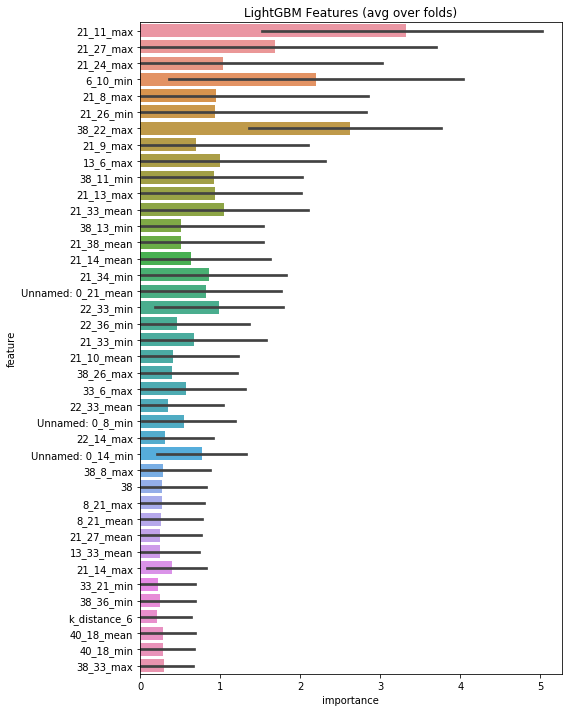

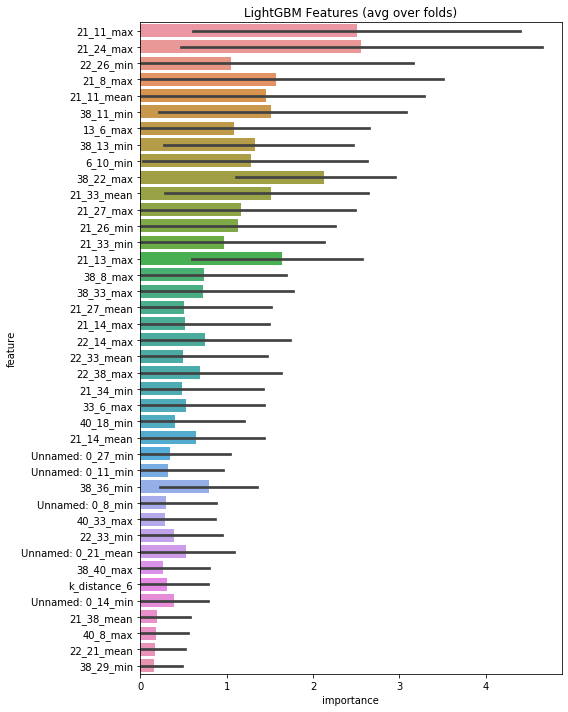

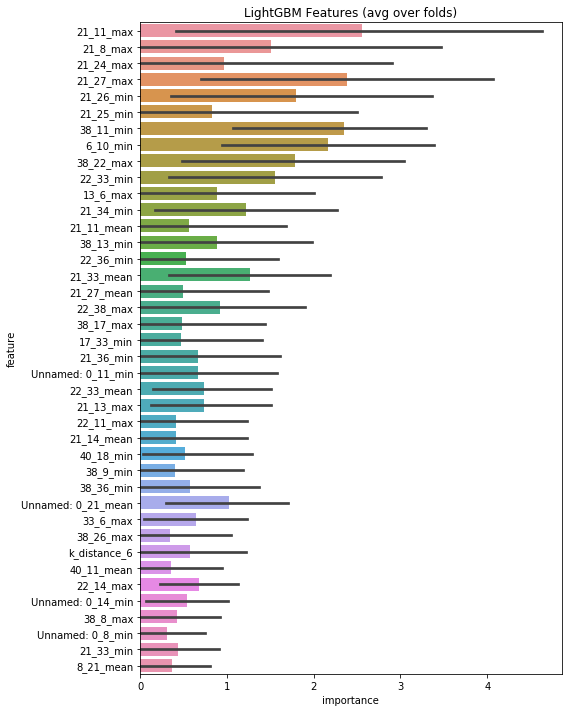

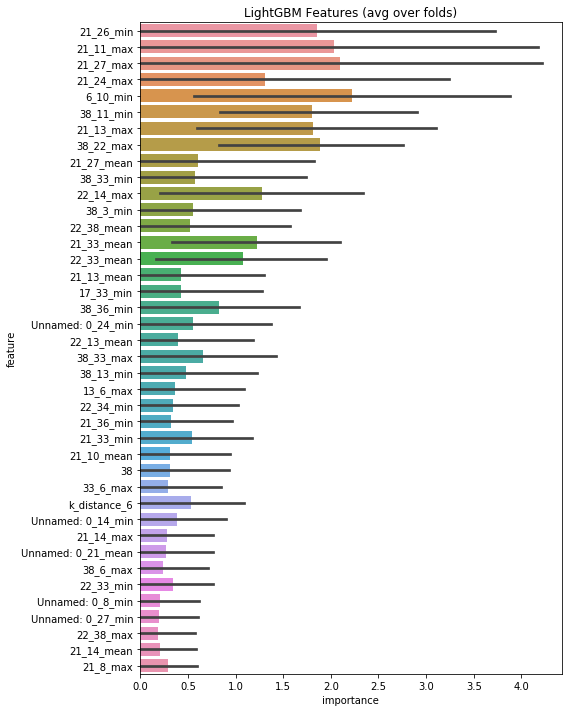

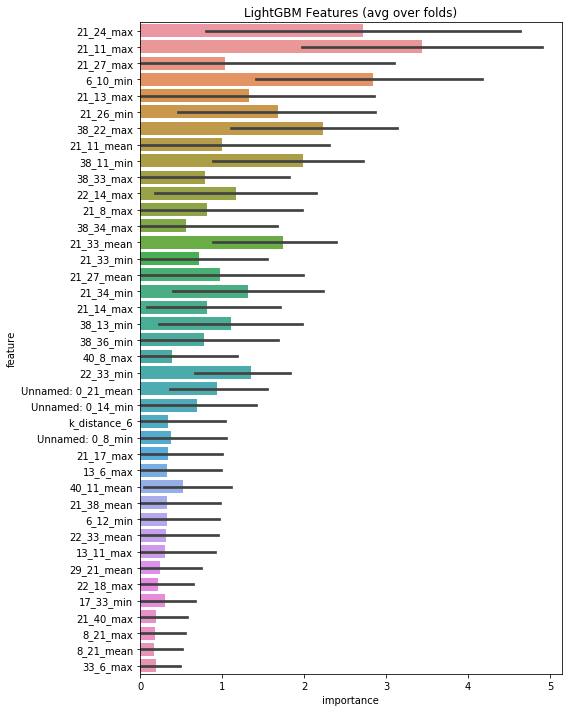

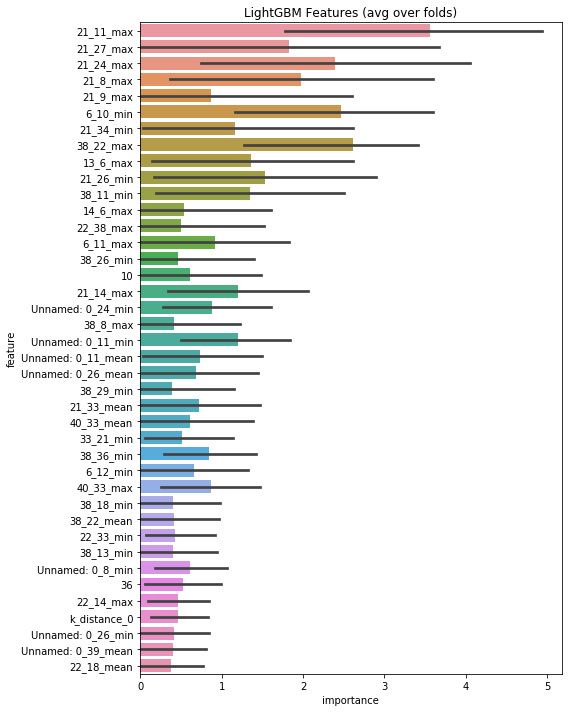

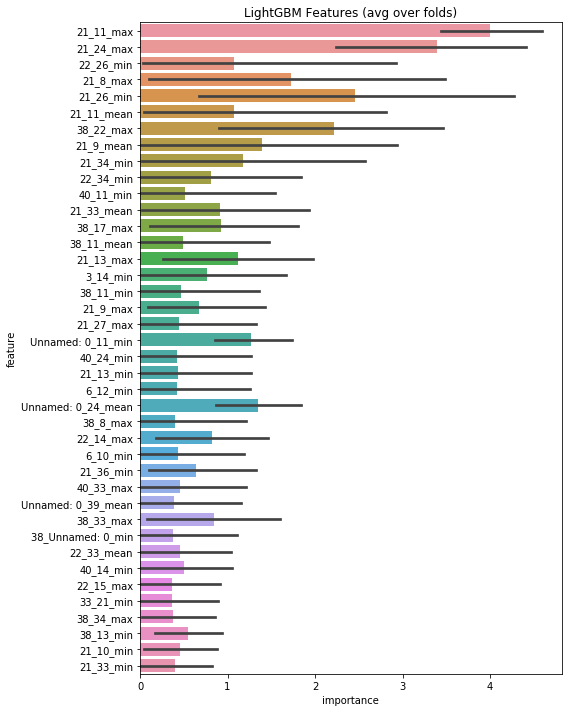

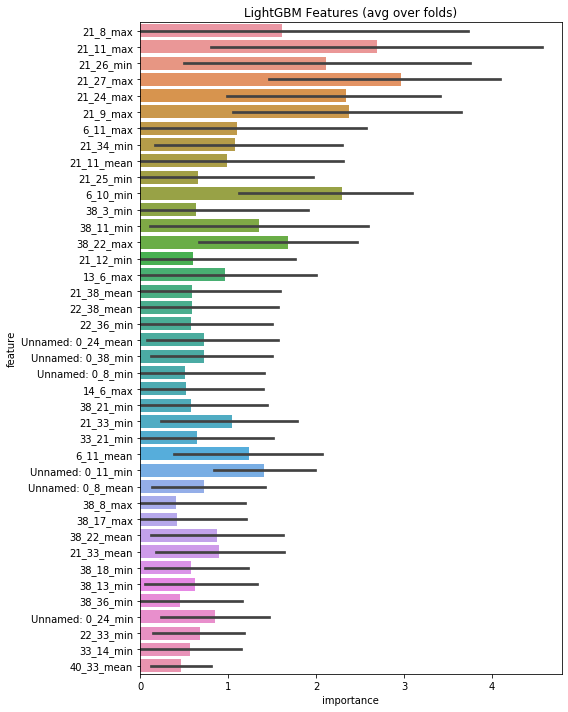

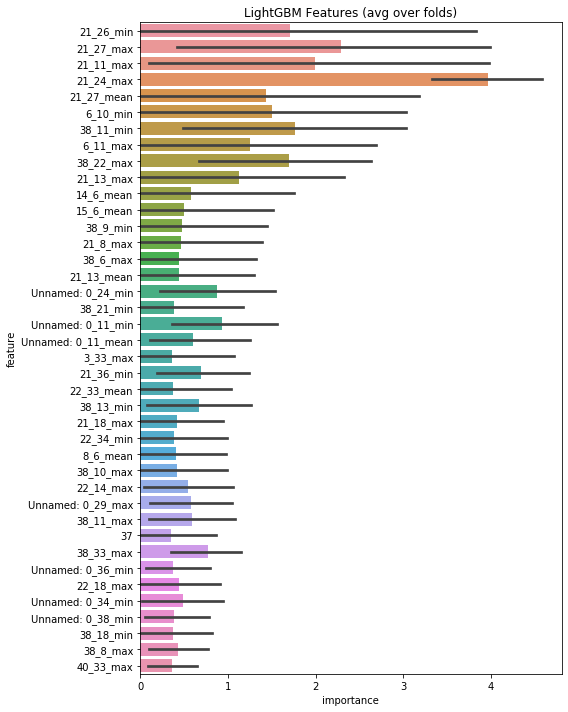

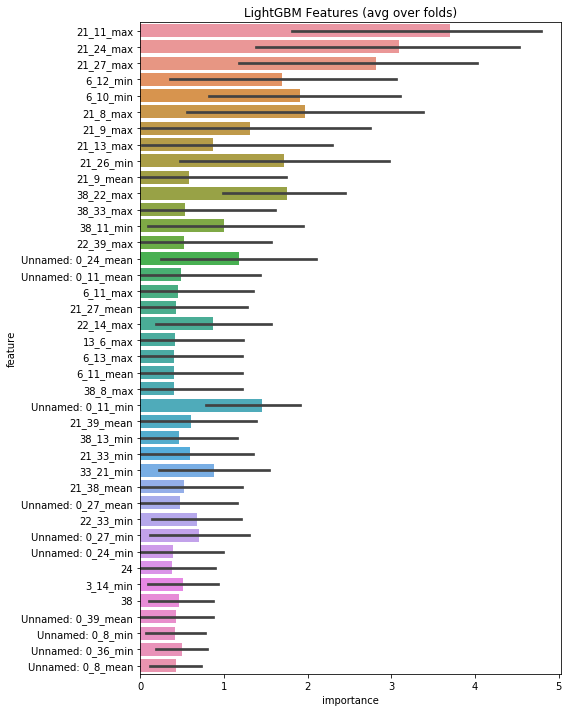

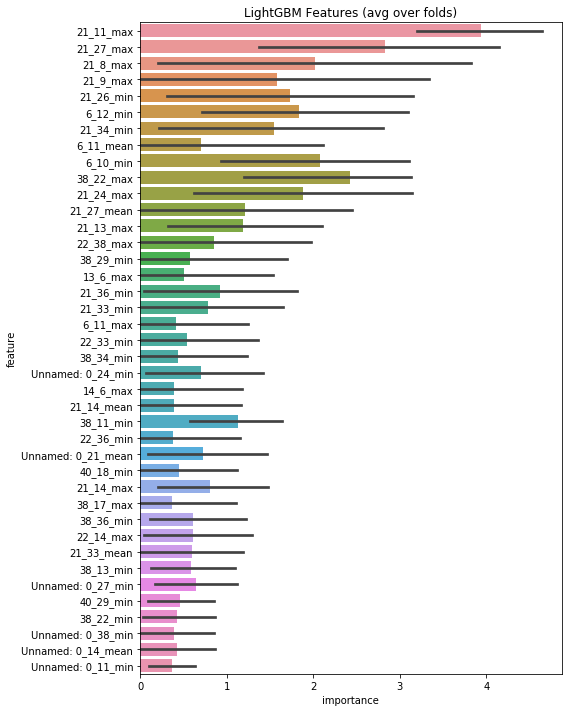

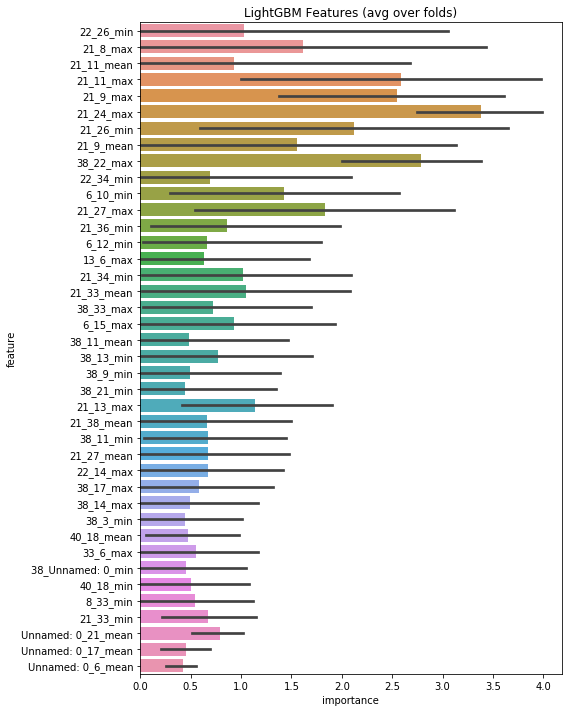

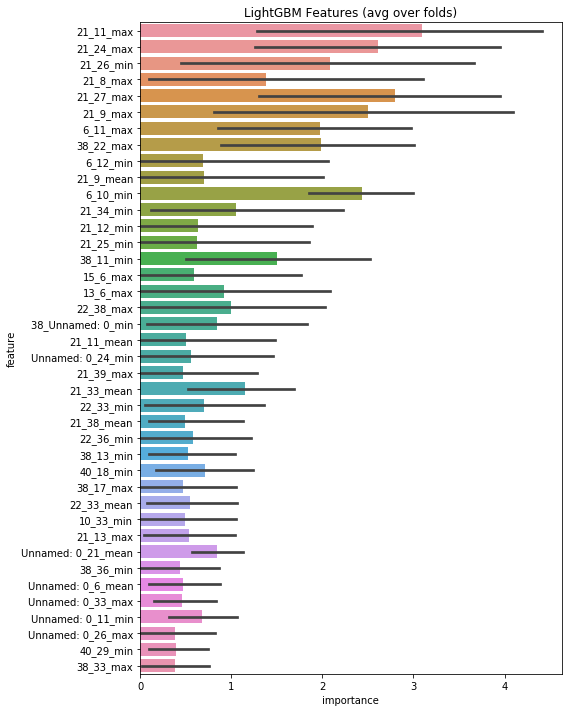

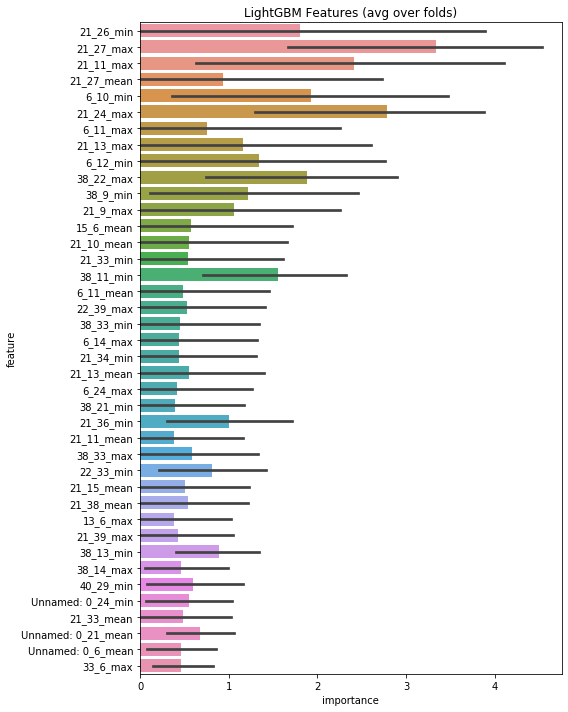

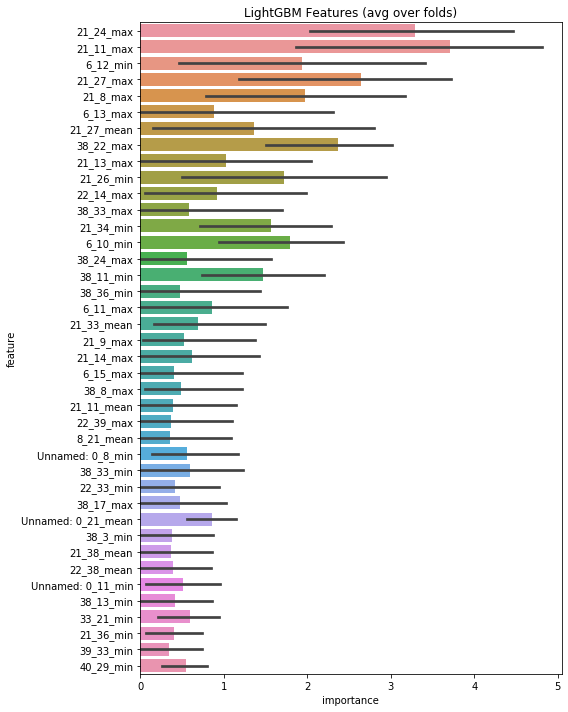

In [8]:
for i in range(0, 3):
    ml.run(scenario)

In [9]:
ml.engine.train.shape

(72, 3795)

In [10]:
ml.predicts

array([0.73497251, 0.78301627, 0.60322469, 0.02159506, 0.01585921,
       0.97939917, 0.01374096, 0.93509509, 0.01159021, 0.02405676,
       0.97814076, 0.9810918 , 0.98280236, 0.87272964, 0.39532125,
       0.88302149, 0.01688495, 0.03047293, 0.01589514, 0.01830779,
       0.02381251, 0.97737459, 0.3868551 , 0.01456575])

In [11]:
actual = pd.read_csv("../input/vortex/vortex_actual_05.csv")
actual["pred"] = ml.predicts
actual.to_csv("actual_05.csv")

In [ ]:
with open("selected.pkl", "rb") as f:
    hoge = pickle.load(f)

In [ ]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
df = pd.concat([train, test])

In [ ]:
train.info()

In [ ]:
train.head()

In [ ]:
scaler = StandardScaler()
scaler.fit(train[["Age", "Fare"]])

train[["Age", "Fare"]] = scaler.transform(train[["Age", "Fare"]])
train["Age"].fillna(-9999, inplace=True)
train["Fare"].fillna(-9999, inplace=True)

In [ ]:
import umap

um = umap.UMAP()
um.fit(train[["Age", "Fare"]])

d = um.transform(train[["Age", "Fare"]])

In [ ]:
d[:, 1]

In [ ]:
train.head()

In [ ]:
train[["Age", "Fare"]] = train[["Age", "Fare"]].replace(np.inf, np.nan)

In [ ]:
df = pd.concat([ml.engine.train, ml.engine.test], ignore_index=True)
skip_columns = ["Survived"]

In [ ]:
feats = [f for f in df.columns if f not in skip_columns]
num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]

In [ ]:
num_columns

In [ ]:
for col in num_columns:
    df[col] = df[col].replace(np.inf, np.nan)
    df[col].fillna(-9999, inplace=True)

In [ ]:
um = umap.UMAP()
um.fit(df[num_columns])
df[num_columns] = um.transform(df[num_columns])

In [ ]:
df[num_columns].shape

In [ ]:
um.transform(df[num_columns])

In [ ]:
base_path = "./"
base_score = 0.7681353456669913

In [ ]:
best_score = 0.0
selected = set([])
params = None
scenario = None
with open(f"{base_path}/param_{base_score}.json") as f:
    params = json.load(f)
with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")

train_x = [f for f in train.columns if f not in ["Survived"]]

In [ ]:
scores = []
for col in train_x:
    if col not in selected:
        feats = list(selected) + [col]
        param_with_score = 1
        scores.append((col, param_with_score))

In [ ]:
b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1])[0]
if b_score > best_score:
    selected.add(b_feature)
    best_score = b_score
    print(f'selected:{b_feature}')
    print(f'score:{b_score}')
else:
    break